# How to win League of Legends?

#### The following notebook shows the results of our joint work on the Machine Learning Course Final Project

## Our goal

We wanted to create a model that would be able to judge the final result of the match from the match statistics from the 10th minute of the game. As data, we used 90 features 45 per team.

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import sklearn.preprocessing

from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from catboost import CatBoostClassifier
from lightgbm  import LGBMClassifier

from skopt import BayesSearchCV

from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

## Data


## Data collecting

We collected data using a hand-written Python class that creates datasets using the [API](https://developer.riotgames.com/) provided by Riot Games. More info about data collecting proccess in the rest of the repository.

### Getting data

We collected 5 datasets with information about games from 5 leagues: bronze, silver, gold, platinum and diamond.
It turned out that there is huge problem with that datasets because data from different lines of the game is mixed.
We tried to restore true data in following "best" datasets.

In [2]:
df_bronze = pd.read_csv("/kaggle/input/ml-project-data/eun1_BRONZE_RANKED_SOLO_CLEAN.csv")
df_silver = pd.read_csv("/kaggle/input/ml-project-data/eun1_SILVER_RANKED_SOLO_CLEAN.csv")
df_gold = pd.read_csv("/kaggle/input/ml-project-data/eun1_GOLD_RANKED_SOLO_CLEAN.csv")
df_platinum = pd.read_csv("/kaggle/input/ml-project-data/eun1_PLATINUM_RANKED_SOLO_CLEAN.csv")
df_diamond = pd.read_csv("/kaggle/input/ml-project-data/eun1_DIAMOND_RANKED_SOLO_CLEAN.csv")


df_bronze_best = pd.read_csv("/kaggle/input/ml-project-data/eun1_BRONZE_RANKED_SOLO_BEST.csv")
df_silver_best = pd.read_csv("/kaggle/input/ml-project-data/eun1_SILVER_RANKED_SOLO_BEST.csv")
df_gold_best = pd.read_csv("/kaggle/input/ml-project-data/eun1_GOLD_RANKED_SOLO_BEST.csv")
df_platinum_best = pd.read_csv("/kaggle/input/ml-project-data/eun1_PLATINUM_RANKED_SOLO_BEST.csv")
df_diamond_best = pd.read_csv("/kaggle/input/ml-project-data/eun1_DIAMOND_RANKED_SOLO_BEST.csv")




dfs={
    'bronze': df_bronze,
    'silver': df_silver,
    'gold': df_gold,
    'platinum': df_platinum,
    'diamond': df_diamond,
}

dfs_best={
    'bronze': df_bronze_best,
    'silver': df_silver_best,
    'gold': df_gold_best,
    'platinum': df_platinum_best,
    'diamond': df_diamond_best,
}

for name, df in dfs_best.items():
    print(name)
    print(len(dfs_best[name]))

bronze
6423
silver
6698
gold
6711
platinum
6409
diamond
10093


Each dataset contains 6-10k rows.

The example rows of data od diamond dataframe:

In [25]:
df_diamond.head()

,match_id,1_win,1_firstDragon,1_MIDDLE_championId,1_MIDDLE_xp_per_min,1_MIDDLE_creeps_per_min,1_MIDDLE_gold_per_min,1_MIDDLE_damage_taken_per_min,1_MIDDLE_first_blood,1_MIDDLE_first_blood_assist,...,2_SUPPORT_first_tower_assist,2_ADC_championId,2_ADC_xp_per_min,2_ADC_creeps_per_min,2_ADC_gold_per_min,2_ADC_damage_taken_per_min,2_ADC_first_blood,2_ADC_first_blood_assist,2_ADC_first_tower,2_ADC_first_tower_assist
0,2725511175,True,False,236,410.5,7.4,293.4,430.0,True,False,...,False,523,340.8,9.4,356.3,186.4,False,False,False,True
1,2710306824,False,True,104,355.7,1.0,312.5,630.6,False,False,...,False,114,395.8,6.1,264.2,508.3,False,False,False,False
2,2677276686,False,True,81,306.5,6.4,262.7,415.7,False,False,...,False,429,292.0,6.1,382.2,330.7,False,False,False,False
3,2713845795,True,True,91,403.3,5.7,270.3,426.6,False,False,...,False,107,404.0,0.6,388.0,886.7,False,False,False,False
4,2596012070,False,False,161,444.0,7.2,276.0,294.8,False,False,...,False,68,457.8,7.0,279.2,460.3,False,False,False,False


To "best" dataset we also translated champion_id to champion_name and for each champion derived its attribute. These are only categorical columns in our dataset. Second column will be the target of our classifiers.

In [27]:
df_diamond_best.head()

,match_id,1_win,1_firstDragon,1_MIDDLE_xp_per_min,1_MIDDLE_creeps_per_min,1_MIDDLE_gold_per_min,1_MIDDLE_damage_taken_per_min,1_MIDDLE_first_blood,1_MIDDLE_first_blood_assist,1_MIDDLE_first_tower,...,2_MIDDLE_champion_name,2_MIDDLE_champion_attribute,2_TOP_champion_name,2_TOP_champion_attribute,2_JUNGLE_champion_name,2_JUNGLE_champion_attribute,2_SUPPORT_champion_name,2_SUPPORT_champion_attribute,2_ADC_champion_name,2_ADC_champion_attribute
0,2725511175,True,False,410.5,7.4,293.4,430.0,True,False,False,...,Kalista,Marksman,Viego,Assassin,Graves,Marksman,Janna,Support,Aphelios,Marksman
1,2710306824,False,True,465.0,7.1,328.0,450.8,False,False,False,...,Tristana,Marksman,Fiora,Fighter,Fiddlesticks,Mage,Senna,Marksman,Tahm Kench,Support
2,2677276686,False,True,437.9,5.5,354.6,578.9,False,False,False,...,Orianna,Mage,Darius,Fighter,Olaf,Fighter,Soraka,Support,Kalista,Marksman
3,2713845795,True,True,403.3,5.7,270.3,426.6,False,False,False,...,Viktor,Mage,Renekton,Fighter,Yone,Assassin,Vel'Koz,Mage,Rengar,Assassin
4,2596012070,False,False,444.0,7.2,276.0,294.8,False,False,False,...,Rumble,Fighter,Sett,Fighter,Rammus,Tank,Pyke,Support,Ezreal,Marksman


### Data pre-processing

We decided to use one hot encode to encode attributes of champions.

In [6]:
from sklearn.preprocessing import OneHotEncoder

def get_rid_of_categorical_columns(df):
    champion_attribute_feats = [col for col in df.columns if col.endswith('champion_attribute')]
    onehotencoder = OneHotEncoder()
    attributes_encoding = onehotencoder.fit_transform(df[champion_attribute_feats]).toarray()
    columns_names_encoding = np.repeat(champion_attribute_feats, 6) 
    categories = ['Assassin', 'Fighter', 'Mage', 'Marksman', 'Support', 'Tank']*10
    columns_names_encoding = [col + "_" + cat for col, cat in zip(columns_names_encoding, categories)]
    to_drop_feats = [col for col in df.columns if col.endswith('champion_attribute') or col.endswith('champion_name')]
    df = df.drop(columns = to_drop_feats)
    return pd.concat([df, pd.DataFrame(attributes_encoding, columns=columns_names_encoding,index=df.index)], axis=1)

for name, df in dfs_best.items():
    dfs_best[name] = get_rid_of_categorical_columns(df)

In [7]:
df = dfs_best['diamond']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10093 entries, 0 to 10092
Columns: 143 entries, match_id to 2_ADC_champion_attribute_Tank
dtypes: bool(42), float64(100), int64(1)
memory usage: 8.2 MB


To leave only significant columns we delete we ones with only one values and the ones which are highly correlated to another column.

In [8]:
def drop_one_value_columns(df):
    to_drop = df.columns[df.nunique()==1]
    print("Dropping one value columns:")
    print(to_drop)
    return df.drop(columns=to_drop)


def drop_high_correlated_columns(df, corr_threshold = 0.95):
    df_corr = df.corr().unstack().reset_index()
    to_drop = df_corr.iloc[:,0][(abs(df_corr.iloc[:,-1])>corr_threshold) & (df_corr.iloc[:,0] < df_corr.iloc[:,1])]
    print("Dropping high correlated columns:")
    print(to_drop)
    return df.drop(columns=to_drop)

bool_columns = df.columns[(df.nunique()<3)]
numerical_columns = df.columns[(df.nunique()>=3)]

for name, df in dfs_best.items():
    dfs_best[name] = drop_one_value_columns(df)
    dfs_best[name] = drop_high_correlated_columns(df)
    
for name, df in dfs.items():
    dfs[name] = drop_one_value_columns(df)
    dfs[name] = drop_high_correlated_columns(df)

Dropping one value columns:
Index(['1_TOP_first_blood_assist', '1_SUPPORT_first_blood_assist',
       '1_JUNGLE_first_blood_assist', '1_MIDDLE_first_blood_assist',
       '1_ADC_first_blood_assist', '2_SUPPORT_first_blood_assist',
       '2_ADC_first_blood_assist', '2_MIDDLE_first_blood_assist',
       '2_JUNGLE_first_blood_assist', '2_TOP_first_blood_assist'],
      dtype='object')
Dropping high correlated columns:
Series([], Name: level_0, dtype: object)
Dropping one value columns:
Index(['1_ADC_first_blood_assist', '1_JUNGLE_first_blood_assist',
       '1_TOP_first_blood_assist', '1_MIDDLE_first_blood_assist',
       '1_SUPPORT_first_blood_assist', '2_ADC_first_blood_assist',
       '2_SUPPORT_first_blood_assist', '2_TOP_first_blood_assist',
       '2_MIDDLE_first_blood_assist', '2_JUNGLE_first_blood_assist'],
      dtype='object')
Dropping high correlated columns:
Series([], Name: level_0, dtype: object)
Dropping one value columns:
Index(['1_TOP_first_blood_assist', '1_SUPPORT_firs

We'll  present our data on histograms. There are all columns with statistics about first team which are not binary. 

array([[<AxesSubplot:title={'center':'1_MIDDLE_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_TOP_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_SUPPORT_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_JUNGLE_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_JUNGLE_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_JUNGLE_gold_per_min'}>,
        <AxesSubplot:

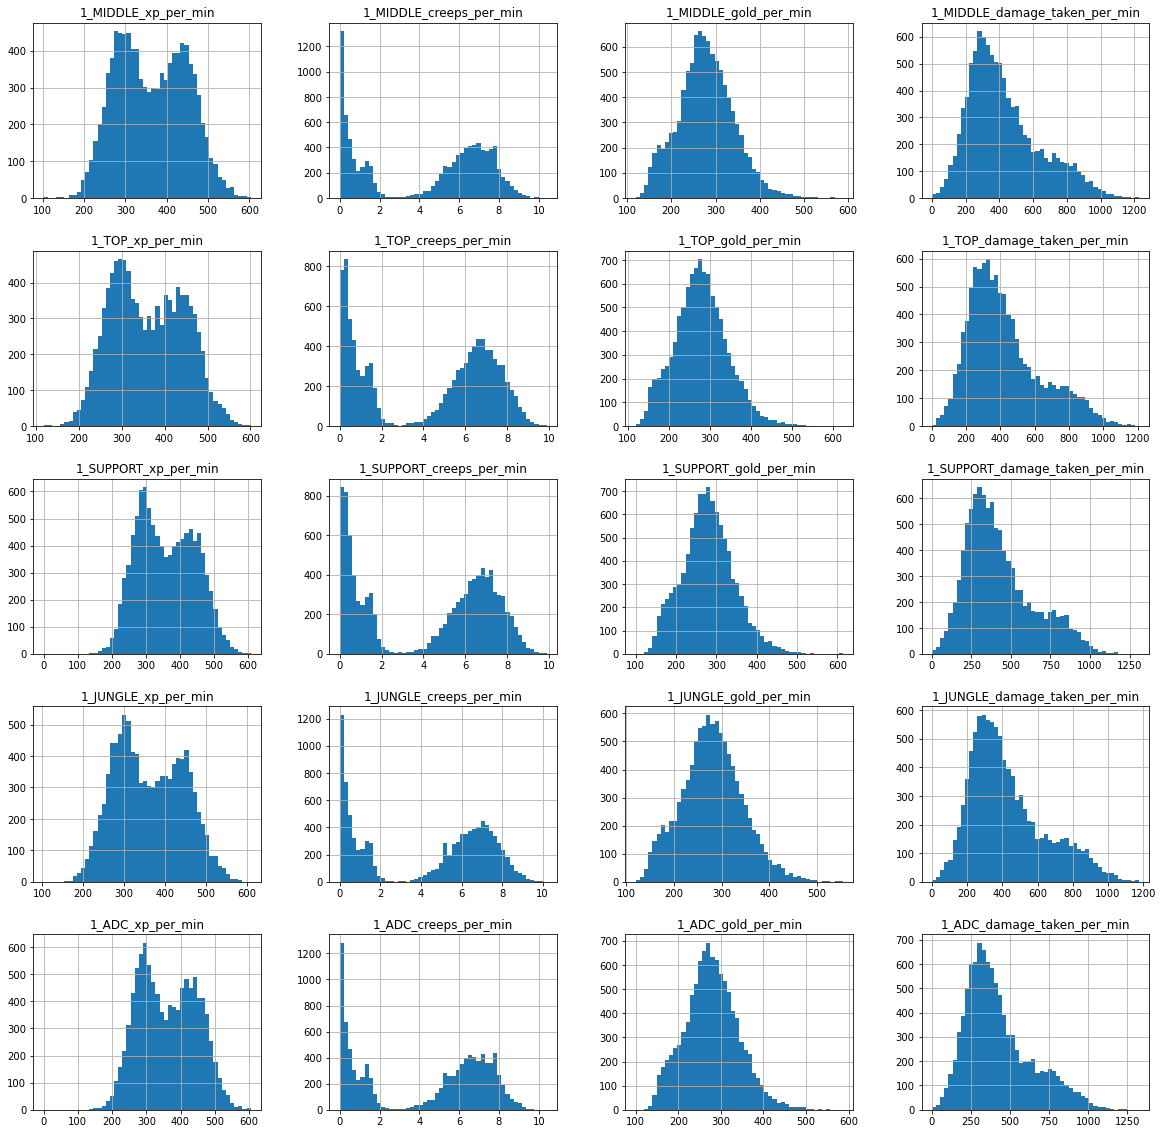

In [31]:
first_team_columns  = [col for col in numerical_columns if col.startswith('1')]
dfs['diamond'][first_team_columns].hist(bins=50, figsize=(20, 20))

We can see that the distribution of data is nice -- we don't strictly need log transformation. There are no visible outliers.
Let's point out that the distribution of features doesn't vary on different lines (middle, top support etc.). This is concerning and it turned out that is because these data are not true.

After our attempt to restore the true distribution of values we obtained these different results.

array([[<AxesSubplot:title={'center':'1_MIDDLE_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_MIDDLE_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_TOP_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_TOP_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_SUPPORT_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_gold_per_min'}>,
        <AxesSubplot:title={'center':'1_SUPPORT_damage_taken_per_min'}>],
       [<AxesSubplot:title={'center':'1_JUNGLE_xp_per_min'}>,
        <AxesSubplot:title={'center':'1_JUNGLE_creeps_per_min'}>,
        <AxesSubplot:title={'center':'1_JUNGLE_gold_per_min'}>,
        <AxesSubplot:

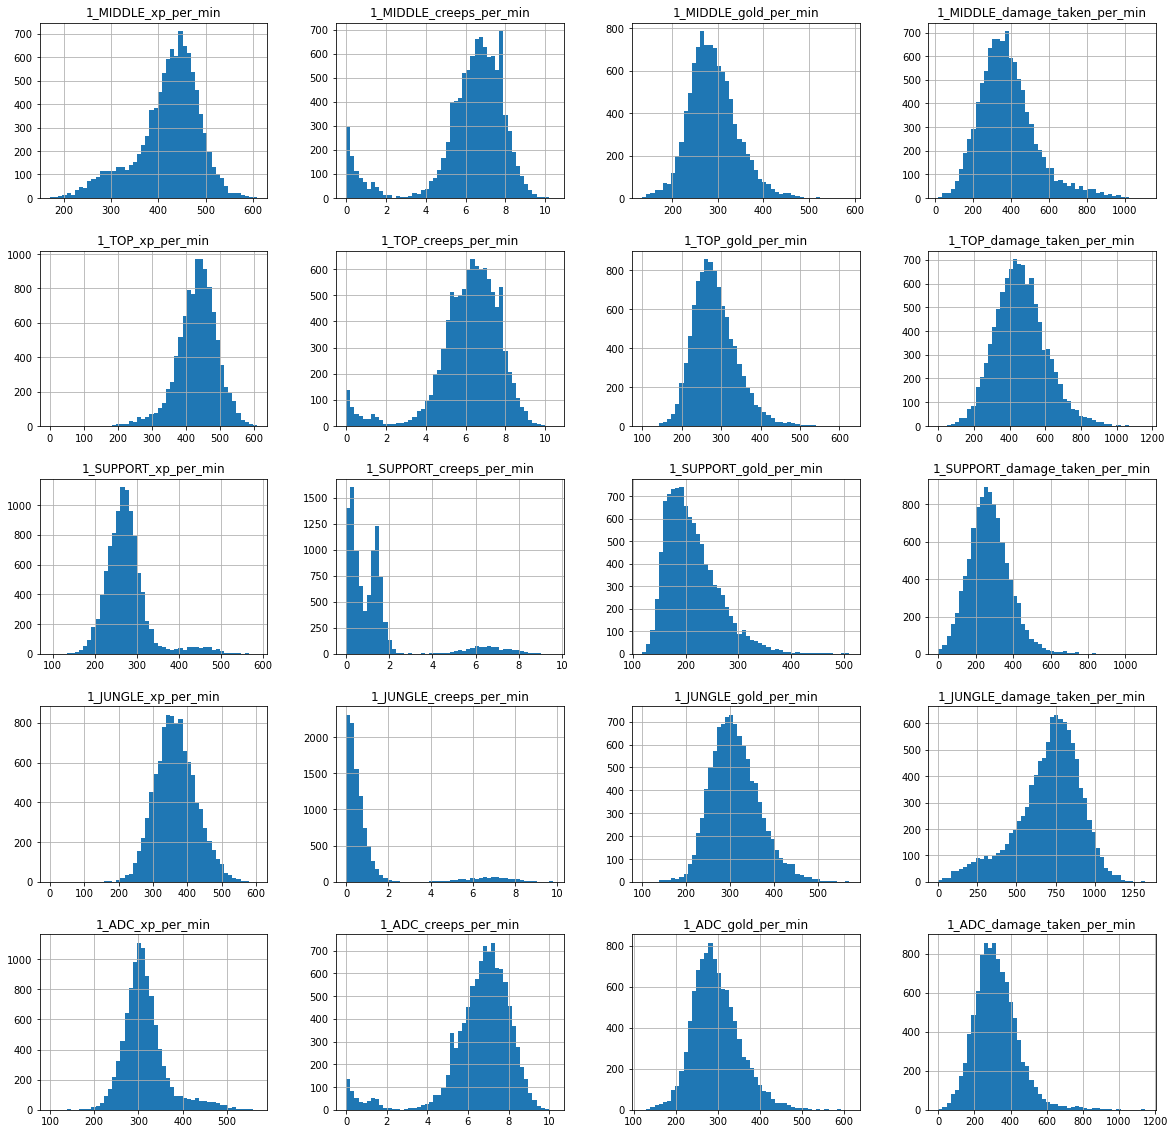

In [32]:
first_team_columns  = [col for col in numerical_columns if col.startswith('1')]
dfs_best['diamond'][first_team_columns].hist(bins=50, figsize=(20, 20))

In the part of preprocessing we also tried to apply some transformations to improve our dataset.
Turned out that it doesn't have visible impact on results and in the and we used simple min-max scaler.

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

def min_max_scaled(df, numerical_columns):
    scaler = MinMaxScaler()
    scaler.fit(df[numerical_columns])
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    return df

def standard_scaled(df, numerical_columns):
    scaler = StandardScaler()
    scaler.fit(df[numerical_columns])
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    return df

def power_yeo_scaled(df, numerical_columns):
    scaler = PowerTransformer(method='yeo-johnson')
    scaler.fit(df[numerical_columns])
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    return df

def power_box_cox_scaled(df, numerical_columns):
    scaler = PowerTransformer(method='box-cox')
    scaler.fit(df[numerical_columns])
    df[numerical_columns] = scaler.transform(df[numerical_columns])
    return df

def PCA_scaled(df):
    scaler = PCA()
    scaler.fit(df.iloc[:,1:])
    df.iloc[:,1:] = scaler.transform(df.iloc[:,1:])
    return df

def PCA_reduced(df, n_components):
    scaler = PCA(n_components = n_components)
    scaler.fit(df.iloc[:,1:])
    print(scaler)
    return pd.concat([df.iloc[:,0], pd.DataFrame(scaler.transform(df.iloc[:,1:]))], axis=1)


for name, df in dfs_best.items():
    dfs_best[name] = min_max_scaled(df, numerical_columns)

In [10]:
dfs_best['diamond'].describe()

,match_id,1_MIDDLE_xp_per_min,1_MIDDLE_creeps_per_min,1_MIDDLE_gold_per_min,1_MIDDLE_damage_taken_per_min,1_TOP_xp_per_min,1_TOP_creeps_per_min,1_TOP_gold_per_min,1_TOP_damage_taken_per_min,1_SUPPORT_xp_per_min,...,2_SUPPORT_champion_attribute_Mage,2_SUPPORT_champion_attribute_Marksman,2_SUPPORT_champion_attribute_Support,2_SUPPORT_champion_attribute_Tank,2_ADC_champion_attribute_Assassin,2_ADC_champion_attribute_Fighter,2_ADC_champion_attribute_Mage,2_ADC_champion_attribute_Marksman,2_ADC_champion_attribute_Support,2_ADC_champion_attribute_Tank
count,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,...,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000,10093.000000
mean,0.914245,0.568958,0.589835,0.342284,0.334574,0.710414,0.591675,0.350667,0.397163,0.369231,...,0.215000,0.073615,0.505400,0.176063,0.019618,0.031804,0.055187,0.862380,0.014763,0.016249
std,0.110858,0.153439,0.197802,0.115536,0.136755,0.095489,0.160854,0.104585,0.121359,0.108168,...,0.410843,0.261157,0.499996,0.380892,0.138689,0.175487,0.228356,0.344518,0.120608,0.126438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.900015,0.495077,0.538462,0.264466,0.242599,0.656163,0.528846,0.277439,0.314018,0.305336,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.956787,0.594687,0.634615,0.332453,0.318578,0.717216,0.615385,0.338415,0.390219,0.357476,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.978975,0.672315,0.711538,0.411221,0.403904,0.772033,0.692308,0.411585,0.471586,0.407588,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Early results

In [35]:
clfs = {
    'SVC': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Ridge Regression': RidgeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False),
    'AdaBoost': AdaBoostClassifier(),
    'Bernouli Naive Bayes': BernoulliNB(),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Simple Neural Network': MLPClassifier(),
    'LGBM': LGBMClassifier(),
}

We wanted to try our data on few pure classifiers with defalut settings.
Here are our early results:

In [36]:
from collections import defaultdict
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [37]:
df_scores = pd.DataFrame(None, columns=['league', 'model', 'unshuffled', 'accuracy'])

for league, df in dfs.items():
    X = df.iloc[:,2:]
    y = df.iloc[:,1]
    model_scores = defaultdict()
    for name, model in clfs.items():
        print('Evaluating {}'.format(name))
        scores = evaluate_model(model, X, y)
        model_scores[name] = scores
    df_temp = pd.DataFrame.from_dict(model_scores)
    df_temp = pd.melt(df_temp)
    df_temp.columns = ['model','accuracy']
    df_temp['league'] = league
    df_temp['unshuffled'] = False
    df_scores = pd.concat([df_scores, df_temp])


Evaluating SVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   24.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   18.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    8.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   23.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   24.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   14.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.3min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   24.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   27.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   22.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   23.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   14.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   18.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   57.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   23.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  6.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   25.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   29.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.1s finished


In [47]:
for league, df in dfs_best.items():
    X = df.iloc[:,2:]
    y = df.iloc[:,1]
    model_scores = defaultdict()
    for name, model in clfs.items():
        print('Evaluating {}'.format(name))
        scores = evaluate_model(model, X, y)
        model_scores[name] = scores
    df_temp = pd.DataFrame.from_dict(model_scores)
    df_temp = pd.melt(df_temp)
    df_temp.columns = ['model','accuracy']
    df_temp['league'] = league
    df_temp['unshuffled'] = True
    df_scores = pd.concat([df_scores, df_temp])

Evaluating SVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   31.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   20.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   36.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   14.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   35.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   13.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   34.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  5.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   19.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating SVC


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Logistic Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Ridge Regression


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Random Forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   20.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  6.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   34.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Bernouli Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Gaussian Naive Bayes


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating KNN


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   35.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating Simple Neural Network


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating LGBM


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.8s finished


Here is shown the performence of different clasifiers on raw and restored dataset (diamond).

Text(0.5, 1.0, 'Performance of Different Models Using 5-Fold Cross-Validation, diamond league')

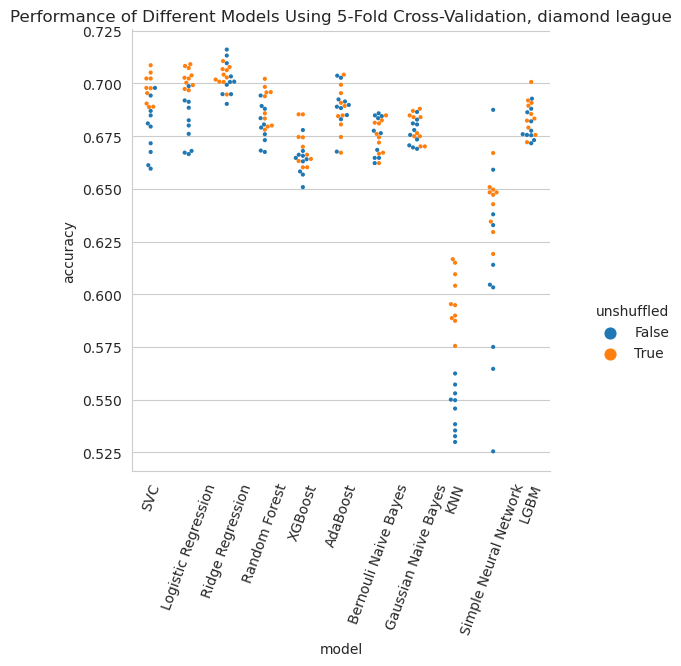

In [158]:
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
filter_diamond = df_scores['league'] == 'diamond'
sns.catplot(x="model", y="accuracy", hue='unshuffled',
            data=df_scores[filter_diamond], kind="swarm", legend_out=True, s = 3)
plt.xticks(rotation=70)
plt.title('Performance of Different Models Using 5-Fold Cross-Validation, diamond league')
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

The comparizon of accuracy of all these classifiers on different leagues and unshuffled dataset.

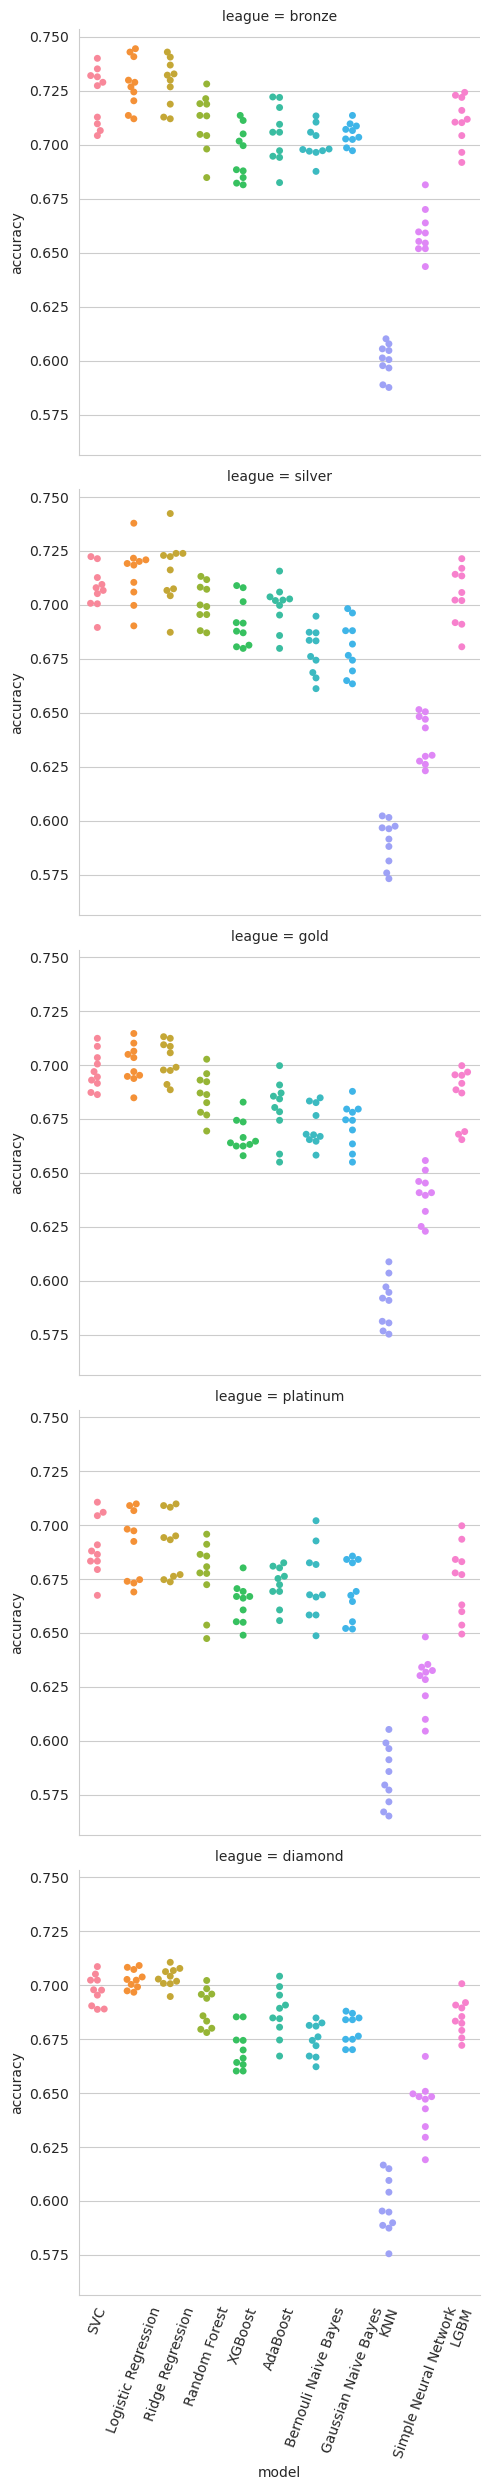

In [157]:
filter_best_df = df_scores['unshuffled'] == True
plt.rcParams['figure.dpi'] = 100
sns.catplot(x="model", y="accuracy", row='league', data=df_scores[filter_best_df], kind="swarm")
plt.xticks(rotation=70)
plt.tight_layout()

We can see that on this stage best performing methods are Rigde regression and logistic regression.
The best results are obtained on bronze league -- up to 72,5% accuracy. The hardest league to predict is diamond -- we can only get 70% accuracy.

In [84]:
filter_best_df_diamond = (df_scores['unshuffled'] == True) & (df_scores['league'] == 'diamond')
df_temp = df_scores[filter_best_df_diamond].groupby(by='model')['accuracy'].apply(list)
model_scores = dict(zip(df_temp.index, df_temp.values))

In [85]:
import plotly.graph_objects as go

def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()
    
plot_results(model_scores, name='base_models_cv')

We also wanted to know if the data from different leagues differs a lot. We tried to train model on the data of one league and predict on other. We use Ridge classifier.

In [104]:
df_results = pd.DataFrame(None, columns=['train_league', 'test_league', 'accuracy'])
model = RidgeClassifier()


for train_league in dfs_best.keys():
    
    df = dfs_best[train_league]
    X = df.iloc[:,2:]
    y = df.iloc[:,1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_scores = defaultdict()
    model = RidgeClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    model_scores[train_league] = acc

    for league, df_league in dfs_best.items():
        if(league != train_league):
            X = df_league.iloc[:,2:]
            y = df_league.iloc[:,1]
            predictions = model.predict(X)
            acc = accuracy_score(y, predictions)
            model_scores[league] = acc

    df_temp = pd.DataFrame.from_dict([model_scores])
    df_temp = pd.melt(df_temp)
    df_temp.columns = ['test_league','accuracy']
    df_temp['train_league'] = train_league
    df_temp
    df_results = pd.concat([df_results, df_temp])
    
df_results.head()

,train_league,test_league,accuracy
0,bronze,bronze,0.733852
1,bronze,silver,0.698865
2,bronze,gold,0.700790
3,bronze,platinum,0.684350
4,bronze,diamond,0.688992


Accuracy doesn't differ a lot. Using platinum as training set gives the best results.

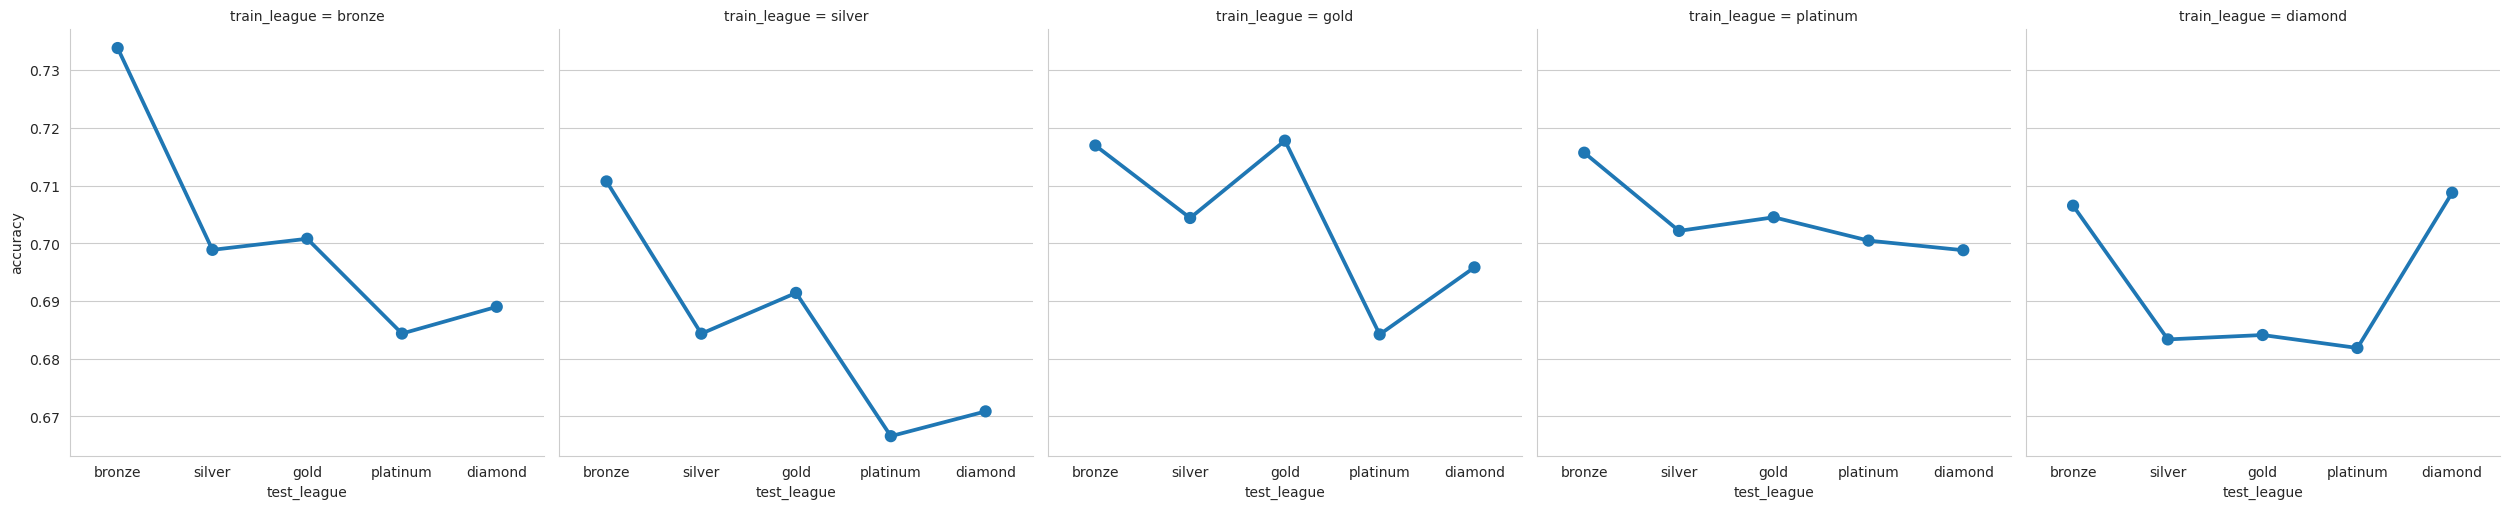

In [160]:
plt.rcParams['figure.dpi'] = 100
sns.catplot(x="test_league", y="accuracy", col='train_league', data=df_results, kind="point")

The easiest to predict is bronze league.

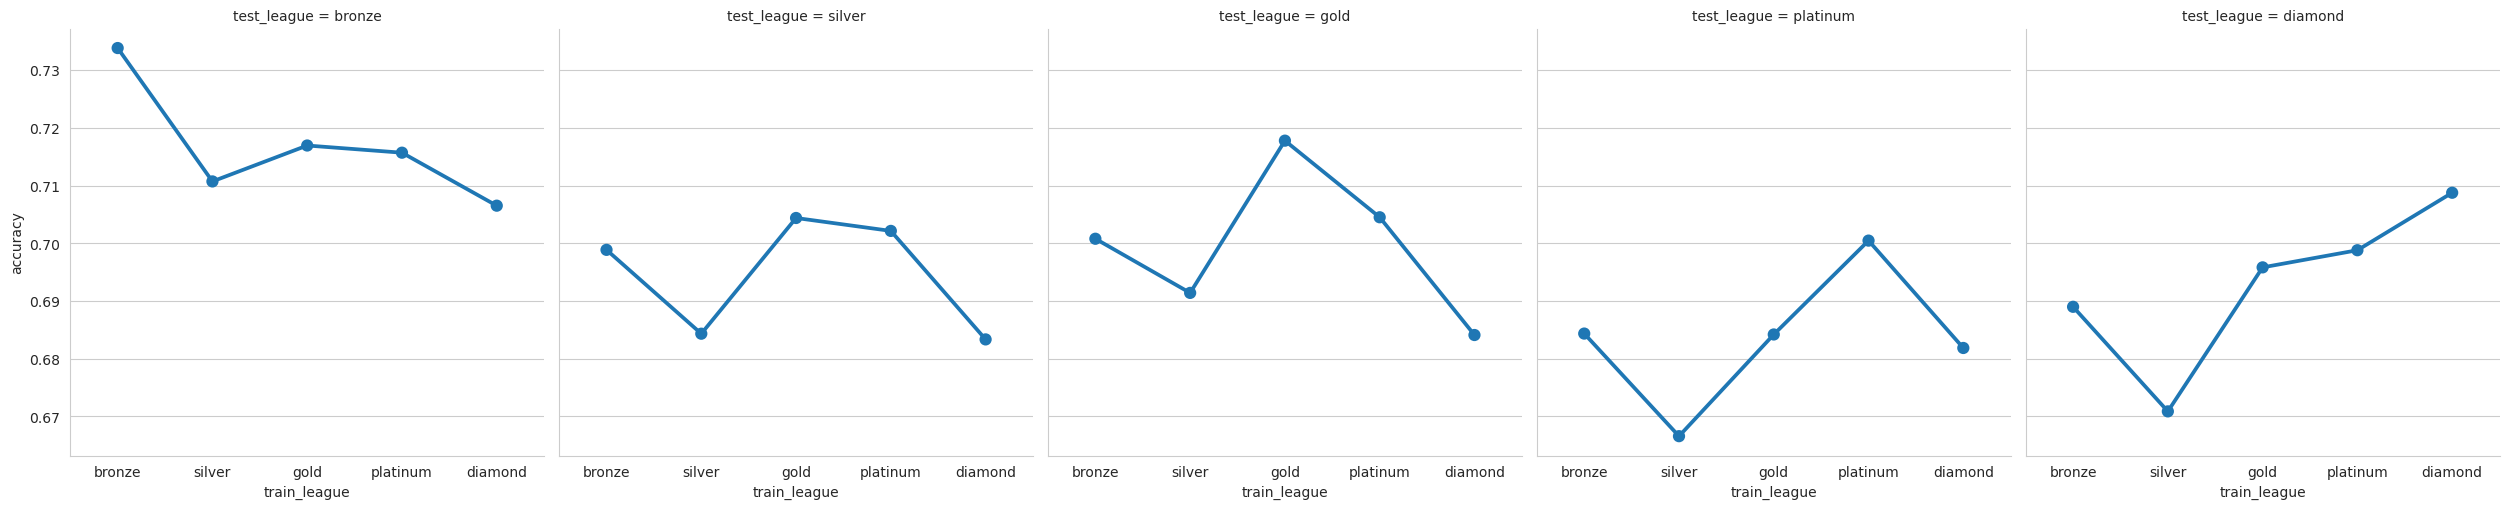

In [161]:
sns.catplot(x="train_league", y="accuracy", col='test_league', data=df_results, kind="point")

# Feature importance

In [12]:
df = dfs_best['bronze']
df = drop_one_value_columns(df)
df.head()

Dropping one value columns:
Index(['1_TOP_first_blood_assist', '1_SUPPORT_first_blood_assist',
       '1_JUNGLE_first_blood_assist', '1_MIDDLE_first_blood_assist',
       '1_ADC_first_blood_assist', '2_SUPPORT_first_blood_assist',
       '2_ADC_first_blood_assist', '2_MIDDLE_first_blood_assist',
       '2_JUNGLE_first_blood_assist', '2_TOP_first_blood_assist'],
      dtype='object')


,match_id,1_win,1_firstDragon,1_TOP_xp_per_min,1_TOP_creeps_per_min,1_TOP_gold_per_min,1_TOP_damage_taken_per_min,1_TOP_first_blood,1_TOP_first_tower,1_TOP_first_tower_assist,...,2_JUNGLE_champion_attribute_Mage,2_JUNGLE_champion_attribute_Marksman,2_JUNGLE_champion_attribute_Support,2_JUNGLE_champion_attribute_Tank,2_TOP_champion_attribute_Assassin,2_TOP_champion_attribute_Fighter,2_TOP_champion_attribute_Mage,2_TOP_champion_attribute_Marksman,2_TOP_champion_attribute_Support,2_TOP_champion_attribute_Tank
0,0.564867,False,False,0.729479,0.602151,0.457201,0.362897,False,False,False,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.958408,False,False,0.647733,0.516129,0.198986,0.360421,False,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.986550,False,True,0.760829,0.623656,0.320284,0.257317,False,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.556943,True,True,0.630710,0.666667,0.248276,0.386772,False,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.965293,False,False,0.362548,0.000000,0.224544,0.592006,False,False,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn import feature_selection

def enc_attrs(series):
    if type(series) != 'str':
        return series
    dic = series.values
    return pd.Series(attr_enc[x] for x in series)

# X = df_attrs.iloc[:,2:][filter(lambda x: x.endswith("attribute"),df_attrs.columns)].apply(enc_attrs)
columns = list(filter(lambda x: x.startswith("1"), df.columns[2:]))
#columns = df.columns[2:]
X = df[columns]
#X = df.iloc[:,2:]
Y = df.iloc[:,1]
fs = feature_selection.SelectKBest(feature_selection.f_classif, k=30)
fs.fit_transform(X,Y)
prs = list(zip(columns,fs.scores_))
# prs.sort(reverse = True,key = lambda x : x[1])
# for p in prs:
#     print(f"feature: {p[0]}, score: {p[1]}")
    
df_feature_importance = pd.DataFrame(None)
df_feature_importance['feature'] = columns
df_feature_importance['score'] = fs.scores_
df_feature_importance.head()

,feature,score
0,1_firstDragon,517.136870
1,1_TOP_xp_per_min,106.568307
2,1_TOP_creeps_per_min,49.587337
3,1_TOP_gold_per_min,184.173996
4,1_TOP_damage_taken_per_min,9.416456


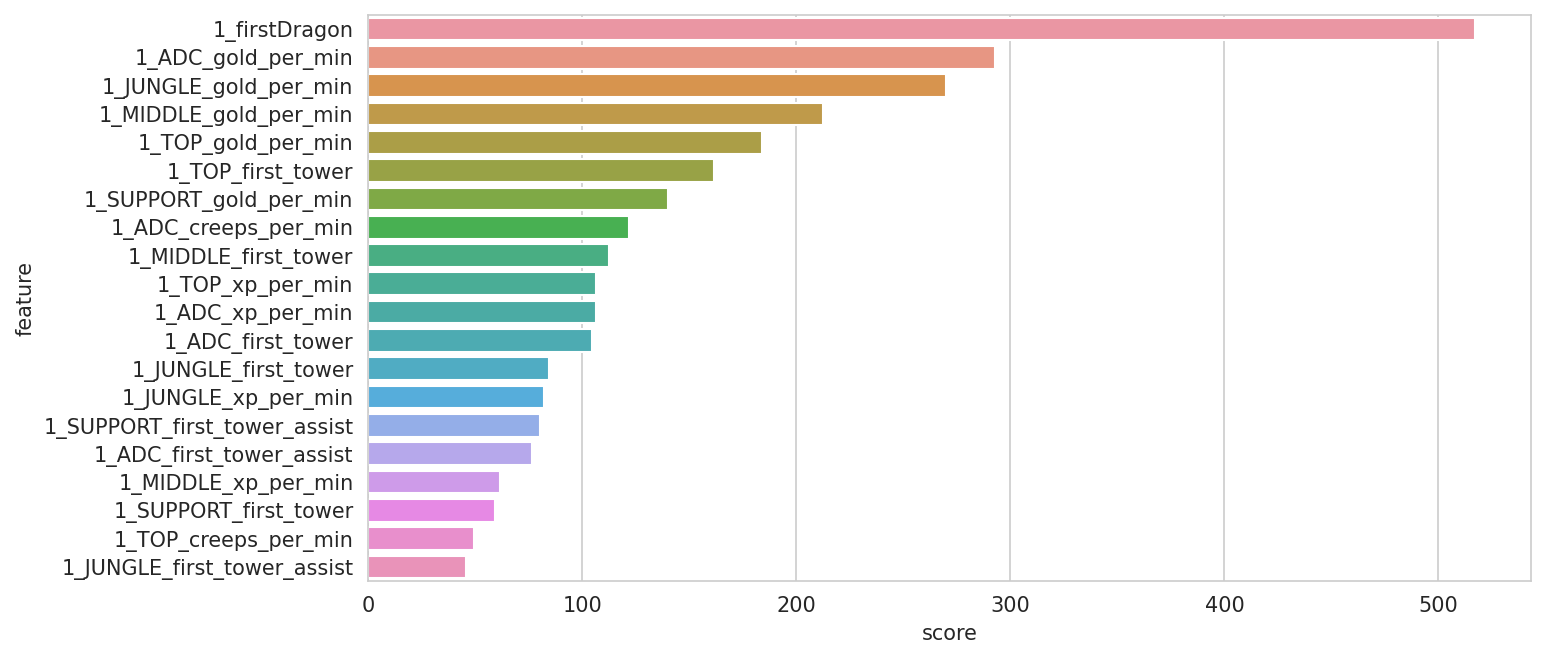

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [10, 5]

df_feature_importance = df_feature_importance.sort_values(by='score', ascending = False)

ax = sns.barplot(x='score', y='feature', data=df_feature_importance[:20])

In [20]:
df = df_diamond_best.copy()
df

,match_id,1_win,1_firstDragon,1_MIDDLE_xp_per_min,1_MIDDLE_creeps_per_min,1_MIDDLE_gold_per_min,1_MIDDLE_damage_taken_per_min,1_MIDDLE_first_blood,1_MIDDLE_first_blood_assist,1_MIDDLE_first_tower,...,2_MIDDLE_champion_name,2_MIDDLE_champion_attribute,2_TOP_champion_name,2_TOP_champion_attribute,2_JUNGLE_champion_name,2_JUNGLE_champion_attribute,2_SUPPORT_champion_name,2_SUPPORT_champion_attribute,2_ADC_champion_name,2_ADC_champion_attribute
0,2725511175,True,False,410.5,7.4,293.4,430.0,True,False,False,...,Kalista,Marksman,Viego,Assassin,Graves,Marksman,Janna,Support,Aphelios,Marksman
1,2710306824,False,True,465.0,7.1,328.0,450.8,False,False,False,...,Tristana,Marksman,Fiora,Fighter,Fiddlesticks,Mage,Senna,Marksman,Tahm Kench,Support
2,2677276686,False,True,437.9,5.5,354.6,578.9,False,False,False,...,Orianna,Mage,Darius,Fighter,Olaf,Fighter,Soraka,Support,Kalista,Marksman
3,2713845795,True,True,403.3,5.7,270.3,426.6,False,False,False,...,Viktor,Mage,Renekton,Fighter,Yone,Assassin,Vel'Koz,Mage,Rengar,Assassin
4,2596012070,False,False,444.0,7.2,276.0,294.8,False,False,False,...,Rumble,Fighter,Sett,Fighter,Rammus,Tank,Pyke,Support,Ezreal,Marksman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10088,2722971050,True,True,366.5,5.6,233.3,337.0,False,False,False,...,Orianna,Mage,Camille,Fighter,Rammus,Tank,Braum,Support,Kai'Sa,Marksman
10089,2706980278,True,False,313.0,6.4,269.4,326.5,False,False,False,...,Katarina,Assassin,Shen,Tank,Jarvan IV,Tank,Thresh,Support,Lucian,Marksman
10090,2703834569,True,True,268.2,1.0,235.3,161.4,False,False,False,...,Kassadin,Assassin,Poppy,Tank,Olaf,Fighter,Leona,Tank,Miss Fortune,Marksman
10091,2706718158,False,False,390.1,4.6,263.4,445.8,False,False,False,...,Cassiopeia,Mage,Irelia,Fighter,Master Yi,Assassin,Thresh,Support,Kai'Sa,Marksman


In [31]:
first_gold_columns = [col for col in df.columns if col.startswith('1') and 'gold' in col]
second_gold_columns = [col for col in df.columns if col.startswith('2') and 'gold' in col]
df['1_mean_gold'] = df[first_gold_columns].apply(np.mean, axis=1)
df['1_gold_std'] = df[first_gold_columns].apply(np.std, axis=1)
df['2_mean_gold'] = df[second_gold_columns].apply(np.mean, axis=1)
df['2_gold_std'] = df[second_gold_columns].apply(np.std, axis=1)

In [35]:
df = get_rid_of_categorical_columns(df)
df = min_max_scaled(df, numerical_columns)
df = drop_high_correlated_columns(df)
df = drop_one_value_columns(df)

columns = list(filter(lambda x: x.startswith("1"), df.columns[2:]))
#columns = df.columns[2:]
X = df[columns]
#X = df.iloc[:,2:]
Y = df.iloc[:,1]
fs = feature_selection.SelectKBest(feature_selection.f_classif, k=30)
fs.fit_transform(X,Y)
prs = list(zip(columns,fs.scores_))
# prs.sort(reverse = True,key = lambda x : x[1])
# for p in prs:
#     print(f"feature: {p[0]}, score: {p[1]}")
    
df_feature_importance = pd.DataFrame(None)
df_feature_importance['feature'] = columns
df_feature_importance['score'] = fs.scores_
df_feature_importance = df_feature_importance.sort_values(by='score', ascending = False)


Dropping high correlated columns:
Series([], Name: level_0, dtype: object)
Dropping one value columns:
Index([], dtype='object')


In [36]:
df_feature_importance[:20]

,feature,score
36,1_mean_gold,1178.134986
0,1_firstDragon,615.910258
3,1_MIDDLE_gold_per_min,292.738062
24,1_JUNGLE_gold_per_min,288.061345
31,1_ADC_gold_per_min,284.639782
...,...,...
48,1_TOP_champion_attribute_Support,0.024204
63,1_ADC_champion_attribute_Fighter,0.003298
66,1_ADC_champion_attribute_Support,0.001732
51,1_SUPPORT_champion_attribute_Fighter,0.001343
